In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io
from PIL import Image, ImageOps, UnidentifiedImageError
import requests
from io import BytesIO

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab

We don't want to use scans that have no Majority Label nor Correct Label as these still need to be looked at by
neurosurgeons to verify if they have hemorrhaging or not

In [3]:
epi = pd.read_csv("Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv", error_bad_lines=False)
clean_epi = epi[(epi['Majority Label'] != '[]') | (epi['Correct Label'].notna()) & (epi['Correct Label'] != '[[], []]') ]

In [4]:
clean_epi.head()

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes
0,1196514,ID_004c4b319.jpg,https://go.centaurlabs.com/problem/1196514,Labeled,"['[{""x"": 0.40818718, ""y"": 0.8623607}, {""x"": 0....",19.0,5.0,"[{""x"": 0.537109375, ""y"": 0.89453125}, {""x"": 0....",1.0,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",0.00,0.968851,NaN,NaN
1,1196682,ID_0237b835f.jpg,https://go.centaurlabs.com/problem/1196682,Ready,"['[{""x"": 0.62959146, ""y"": 0.720186}, {""x"": 0.6...",51.0,28.0,"[{""x"": 0.654296875, ""y"": 0.724609375}, {""x"": 0...",1.0,NaN,NaN,0.063519,NaN,NaN
2,1196477,ID_02e2d273d.jpg,https://go.centaurlabs.com/problem/1196477,Labeled,"['[{""x"": 0.35205495, ""y"": 0.34680602}, {""x"": 0...",22.0,6.0,"[{""x"": 0.46484375, ""y"": 0.357421875}, {""x"": 0....",1.0,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",0.06,0.710300,NaN,NaN
3,1196612,ID_02f37ce84.jpg,https://go.centaurlabs.com/problem/1196612,Ready,"['[{""x"": 0.3680166, ""y"": 0.48387372}, {""x"": 0....",51.0,29.0,"[{""x"": 0.431640625, ""y"": 0.607421875}, {""x"": 0...",2.0,NaN,NaN,0.264134,NaN,NaN
4,1196612,ID_02f37ce84.jpg,https://go.centaurlabs.com/problem/1196612,Ready,"['[{""x"": 0.3680166, ""y"": 0.48387372}, {""x"": 0....",51.0,29.0,"[{""x"": 0.353515625, ""y"": 0.59765625}, {""x"": 0....",2.0,NaN,NaN,0.264134,NaN,NaN


In [5]:
intra = pd.read_csv("Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv",error_bad_lines=False)
clean_intra = intra[(intra['Majority Label'] != '[]') | (intra['Correct Label'].notna()) & (intra['Correct Label'] != '[[]]') ]
#not sure what to do with scans that have "Gold Standard" (as their labeling state) since some of these have nans for both
#Majority Label and Correct Label
intra.shape
#original excel file has 1373 rows, not exactly sure why pd only reads 1289 even after deleting
#the "error_bad_lines=False" command

(1289, 14)

In [6]:
clean_intra.head()

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes
0,1675660,ID_0002081b6.jpg,https://go.centaurlabs.com/problem/1675660,In Progress,"['[{""x"": 0.31658885, ""y"": 0.48357323}, {""x"": 0...",22.0,9.0,"[{""x"": 0.3046875, ""y"": 0.484375}, {""x"": 0.3046...",1.0,NaN,NaN,0.224542,NaN,NaN
1,1675942,ID_0048e60a4.jpg,https://go.centaurlabs.com/problem/1675942,In Progress,"['[{""x"": 0.54811704, ""y"": 0.5961946}, {""x"": 0....",22.0,7.0,"[{""x"": 0.5859375, ""y"": 0.640625}, {""x"": 0.5859...",1.0,NaN,NaN,0.772365,NaN,NaN
2,1197689,ID_0057d2736.jpg,https://go.centaurlabs.com/problem/1197689,Labeled,"['[{""x"": 0.3040109, ""y"": 0.52168596}, {""x"": 0....",46.0,9.0,"[{""x"": 0.3046875, ""y"": 0.521484375}, {""x"": 0.3...",1.0,"[[{'x': 0.3046875, 'y': 0.521484375}, {'x': 0....",0.02,0.738368,NaN,NaN
3,1197754,ID_007cac3b7.jpg,https://go.centaurlabs.com/problem/1197754,Labeled,"['[{""x"": 0.41792268, ""y"": 0.56897116}, {""x"": 0...",51.0,10.0,"[{""x"": 0.41015625, ""y"": 0.615234375}, {""x"": 0....",1.0,"[[{'x': 0.4140625, 'y': 0.6171875}, {'x': 0.41...",0.03,0.618086,NaN,NaN
4,1675775,ID_00b46c6bc.jpg,https://go.centaurlabs.com/problem/1675775,In Progress,"['[{""x"": 0.82215744, ""y"": 0.20116618}, {""x"": 0...",22.0,6.0,"[{""x"": 0.365234375, ""y"": 0.693359375}, {""x"": 0...",1.0,NaN,NaN,0.006388,NaN,NaN


In [7]:
multiple = pd.read_csv("Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv",error_bad_lines=False )
#again, excel file has more rows but pd reading less
clean_multiple = multiple[(multiple['Majority Label'] != '[]') | (multiple['Correct Label'].notna()) & (multiple['Correct Label'] != '[[]]') ]
multiple.shape

(1054, 14)

In [8]:
clean_multiple.head()

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes
0,1198534,ID_01af922c3.jpg,https://go.centaurlabs.com/problem/1198534,In Progress,"['[{""x"": 0.372072, ""y"": 0.6399058}, {""x"": 0.36...",23.0,6.0,"[{""x"": 0.396484375, ""y"": 0.73046875}, {""x"": 0....",3.0,NaN,NaN,0.790347,NaN,NaN
1,1198534,ID_01af922c3.jpg,https://go.centaurlabs.com/problem/1198534,In Progress,"['[{""x"": 0.372072, ""y"": 0.6399058}, {""x"": 0.36...",23.0,6.0,"[{""x"": 0.619140625, ""y"": 0.765625}, {""x"": 0.61...",3.0,NaN,NaN,0.790347,NaN,NaN
2,1198534,ID_01af922c3.jpg,https://go.centaurlabs.com/problem/1198534,In Progress,"['[{""x"": 0.372072, ""y"": 0.6399058}, {""x"": 0.36...",23.0,6.0,"[{""x"": 0.46875, ""y"": 0.607421875}, {""x"": 0.468...",3.0,NaN,NaN,0.790347,NaN,NaN
3,1198791,ID_01c457a64.jpg,https://go.centaurlabs.com/problem/1198791,Labeled,"['[{""x"": 0.40734115, ""y"": 0.5586468}, {""x"": 0....",34.0,6.0,"[{""x"": 0.4375, ""y"": 0.7109375}, {""x"": 0.4375, ...",3.0,"[[{'x': 0.548828125, 'y': 0.6796875}, {'x': 0....",0.48,0.124994,NaN,NaN
4,1198791,ID_01c457a64.jpg,https://go.centaurlabs.com/problem/1198791,Labeled,"['[{""x"": 0.40734115, ""y"": 0.5586468}, {""x"": 0....",34.0,6.0,"[{""x"": 0.546875, ""y"": 0.671875}, {""x"": 0.54687...",3.0,"[[{'x': 0.548828125, 'y': 0.6796875}, {'x': 0....",0.48,0.124994,NaN,NaN


In [9]:
subarachnoid = pd.read_csv("Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv", error_bad_lines=False)
clean_subarachnoid = subarachnoid[(subarachnoid['Majority Label'] != '[]') | (subarachnoid['Correct Label'].notna()) & (subarachnoid['Correct Label'] != '[[]]') ]
subarachnoid.shape
#original excel file has 1054 rows, not exactly sure why pd only reads 1031 even after deleting
#the "error_bad_lines=False" command

(1031, 14)

In [10]:
clean_subarachnoid.head()

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes
0,1197112,ID_001b1b944.jpg,https://go.centaurlabs.com/problem/1197112,In Progress,"['[{""x"": 0.43056944, ""y"": 0.5936399}, {""x"": 0....",16.0,5.0,"[{""x"": 0.314453125, ""y"": 0.75}, {""x"": 0.314453...",3.0,NaN,NaN,0.252748,NaN,NaN
1,1197112,ID_001b1b944.jpg,https://go.centaurlabs.com/problem/1197112,In Progress,"['[{""x"": 0.43056944, ""y"": 0.5936399}, {""x"": 0....",16.0,5.0,"[{""x"": 0.400390625, ""y"": 0.796875}, {""x"": 0.40...",3.0,NaN,NaN,0.252748,NaN,NaN
2,1197112,ID_001b1b944.jpg,https://go.centaurlabs.com/problem/1197112,In Progress,"['[{""x"": 0.43056944, ""y"": 0.5936399}, {""x"": 0....",16.0,5.0,"[{""x"": 0.556640625, ""y"": 0.302734375}, {""x"": 0...",3.0,NaN,NaN,0.252748,NaN,NaN
3,1197367,ID_005f428d2.jpg,https://go.centaurlabs.com/problem/1197367,Labeled,"['[{""x"": 0.59604716, ""y"": 0.4975766}, {""x"": 0....",29.0,5.0,"[{""x"": 0.54296875, ""y"": 0.763671875}, {""x"": 0....",2.0,"[[{'x': 0.626953125, 'y': 0.30078125}, {'x': 0...",0.33,0.763632,NaN,NaN
4,1197367,ID_005f428d2.jpg,https://go.centaurlabs.com/problem/1197367,Labeled,"['[{""x"": 0.59604716, ""y"": 0.4975766}, {""x"": 0....",29.0,5.0,"[{""x"": 0.630859375, ""y"": 0.30078125}, {""x"": 0....",2.0,"[[{'x': 0.626953125, 'y': 0.30078125}, {'x': 0...",0.33,0.763632,NaN,NaN


In [11]:
subdural1 = pd.read_csv("Results_Subdural Hemorrhage Detection_2020-11-16_21.35.48.040.csv",error_bad_lines=False)
clean_subdural1 = subdural1[(subdural1['Majority Label'] != '[]') | (subdural1['Correct Label'].notna()) & (subdural1['Correct Label'] != '[[]]')]

In [12]:
clean_subdural1.head()

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes
0,1198320,ID_0061cb462.jpg,https://go.centaurlabs.com/problem/1198320,Labeled,"['[{""x"": 0.4823523, ""y"": 0.59177}, {""x"": 0.473...",16.0,5.0,"[{""x"": 0.45703125, ""y"": 0.78125}, {""x"": 0.4570...",2.0,"[[{'x': 0.40625, 'y': 0.330078125}, {'x': 0.40...",0.29,0.949092,NaN,NaN
1,1198320,ID_0061cb462.jpg,https://go.centaurlabs.com/problem/1198320,Labeled,"['[{""x"": 0.4823523, ""y"": 0.59177}, {""x"": 0.473...",16.0,5.0,"[{""x"": 0.404296875, ""y"": 0.333984375}, {""x"": 0...",2.0,"[[{'x': 0.40625, 'y': 0.330078125}, {'x': 0.40...",0.29,0.949092,NaN,NaN
2,1198004,ID_0086b5e67.jpg,https://go.centaurlabs.com/problem/1198004,In Progress,"['[{""x"": 0.5224404, ""y"": 0.8304443}, {""x"": 0.5...",15.0,6.0,"[{""x"": 0.521484375, ""y"": 0.83203125}, {""x"": 0....",2.0,NaN,NaN,0.157037,NaN,NaN
3,1198004,ID_0086b5e67.jpg,https://go.centaurlabs.com/problem/1198004,In Progress,"['[{""x"": 0.5224404, ""y"": 0.8304443}, {""x"": 0.5...",15.0,6.0,"[{""x"": 0.478515625, ""y"": 0.83984375}, {""x"": 0....",2.0,NaN,NaN,0.157037,NaN,NaN
4,1198353,ID_00eb6f7cc.jpg,https://go.centaurlabs.com/problem/1198353,Labeled,"['[{""x"": 0.48163298, ""y"": 0.71568763}, {""x"": 0...",15.0,5.0,"[{""x"": 0.447265625, ""y"": 0.73828125}, {""x"": 0....",1.0,"[[{'x': 0.447265625, 'y': 0.73828125}, {'x': 0...",0.00,0.306828,NaN,NaN


In [13]:
subdural2 = pd.read_csv("Results_Subdural Hemorrhage Detection_2020-11-16_21.37.19.745.csv",error_bad_lines=False)
clean_subdural2 = subdural2[(subdural2['Majority Label'] != '[]') | (subdural2['Correct Label'].notna()) & (subdural2['Correct Label'] != '[[]]')]

In [14]:
clean_subdural2.head()

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes
0,1198320,ID_0061cb462.jpg,https://go.centaurlabs.com/problem/1198320,Labeled,"['[{""x"": 0.4823523, ""y"": 0.59177}, {""x"": 0.473...",16.0,5.0,"[{""x"": 0.45703125, ""y"": 0.78125}, {""x"": 0.4570...",2.0,"[[{'x': 0.40625, 'y': 0.330078125}, {'x': 0.40...",0.29,0.949092,NaN,NaN
1,1198320,ID_0061cb462.jpg,https://go.centaurlabs.com/problem/1198320,Labeled,"['[{""x"": 0.4823523, ""y"": 0.59177}, {""x"": 0.473...",16.0,5.0,"[{""x"": 0.404296875, ""y"": 0.333984375}, {""x"": 0...",2.0,"[[{'x': 0.40625, 'y': 0.330078125}, {'x': 0.40...",0.29,0.949092,NaN,NaN
2,1198004,ID_0086b5e67.jpg,https://go.centaurlabs.com/problem/1198004,In Progress,"['[{""x"": 0.5224404, ""y"": 0.8304443}, {""x"": 0.5...",15.0,6.0,"[{""x"": 0.521484375, ""y"": 0.83203125}, {""x"": 0....",2.0,NaN,NaN,0.157037,NaN,NaN
3,1198004,ID_0086b5e67.jpg,https://go.centaurlabs.com/problem/1198004,In Progress,"['[{""x"": 0.5224404, ""y"": 0.8304443}, {""x"": 0.5...",15.0,6.0,"[{""x"": 0.478515625, ""y"": 0.83984375}, {""x"": 0....",2.0,NaN,NaN,0.157037,NaN,NaN
4,1198353,ID_00eb6f7cc.jpg,https://go.centaurlabs.com/problem/1198353,Labeled,"['[{""x"": 0.48163298, ""y"": 0.71568763}, {""x"": 0...",15.0,5.0,"[{""x"": 0.447265625, ""y"": 0.73828125}, {""x"": 0....",1.0,"[[{'x': 0.447265625, 'y': 0.73828125}, {'x': 0...",0.00,0.306828,NaN,NaN


In [15]:
# adding label column to all the dataframes
# ignore the warnings

# mapping of dummy label to class
label_key = {0: "epi", 1: "intra", 2: "multi", 3: "subarachnoid", 4: "subdural", 5: "intraventricular"}

clean_epi["label"] = 0
clean_intra["label"] = 1
clean_multiple["label"] = 2
clean_subarachnoid["label"] = 3
clean_subdural2["label"] = 4

<ipython-input-15-361e7f8991e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_epi["label"] = 0
<ipython-input-15-361e7f8991e3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_intra["label"] = 1
<ipython-input-15-361e7f8991e3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [16]:
# removing flagged images
with open("flagged.txt", "r") as f:
    lines = f.readlines()
flagged = []
for l in lines:
    flagged.append(l.strip())
clean_epi = clean_epi.drop(clean_epi[clean_epi["Origin"].isin(flagged)].index)
clean_intra = clean_intra.drop(clean_intra[clean_intra["Origin"].isin(flagged)].index)
clean_multiple = clean_multiple.drop(clean_multiple[clean_multiple["Origin"].isin(flagged)].index)
clean_subarachnoid = clean_subarachnoid.drop(clean_subarachnoid[clean_subarachnoid["Origin"].isin(flagged)].index)
clean_subdural2 = clean_subdural2.drop(clean_subdural2[clean_subdural2["Origin"].isin(flagged)].index)

In [17]:
#adding images to the cleaned epidural dataframe
root_url = 'https://raw.githubusercontent.com/Red-Nova/MATH4570-Project-Data/main/BrainCT/'
class_to_df_dict = {'epidural':clean_epi,'intraparenchymal':clean_intra, 'multi': clean_multiple, 'subarachnoid':clean_subarachnoid,'subdural':clean_subdural2}

img_list = []
for class_name,df in ({'epidural':clean_epi}).items():

    for idx,fname in enumerate(df['Origin']):
        #for now, only process the brain window
        response = requests.get(url=f'{root_url}{class_name}/{class_name}/brain_window/{fname}')
        img = Image.open(BytesIO(response.content))
        img = ImageOps.grayscale(img)
        img = np.asarray(img)
        img = np.reshape(img, (512*512))
        img_list.append(img)

    img_df = pd.DataFrame({'image_matrix': img_list})
    clean_epi = pd.concat([df, img_df], axis=1)
    img_list = [] #reset the image list for the next dataframe

In [18]:
#adding images to the cleaned intraparenchymal dataframe
img_list = []
for class_name,df in ({'intraparenchymal':clean_intra}).items():

    for idx,fname in enumerate(df['Origin']):
        #for now, only process the brain window
        response = requests.get(url=f'{root_url}{class_name}/{class_name}/brain_window/{fname}')
        img = Image.open(BytesIO(response.content))
        img = ImageOps.grayscale(img)
        img = np.asarray(img)
        img = np.reshape(img, (512*512))
        img_list.append(img)

    img_df = pd.DataFrame({'image_matrix': img_list})
    clean_intra = pd.concat([df, img_df], axis=1)
    img_list = [] #reset the image list for the next dataframe

In [19]:
#adding images to the cleaned multiple dataframe
for class_name,df in ({'multi': clean_multiple}).items():

    for idx,fname in enumerate(df['Origin']):
        #for now, only process the brain window
        response = requests.get(url=f'{root_url}{class_name}/{class_name}/brain_window/{fname}')
        img = Image.open(BytesIO(response.content))
        img = ImageOps.grayscale(img)
        img = np.asarray(img)
        img = np.reshape(img, (512*512))
        img_list.append(img)

    img_df = pd.DataFrame({'image_matrix': img_list})
    clean_multiple = pd.concat([df, img_df], axis=1)
    img_list = [] #reset the image list for the next dataframe

In [20]:
#adding images to the cleaned subarachnoid dataframe
img_list = []
for class_name,df in ({'subarachnoid':clean_subarachnoid}).items():

    for idx,fname in enumerate(df['Origin']):
        #for now, only process the brain window
        response = requests.get(url=f'{root_url}{class_name}/{class_name}/brain_window/{fname}')
        try:
            img = Image.open(BytesIO(response.content))
            img = ImageOps.grayscale(img)
            img = np.asarray(img)
            img = np.reshape(img, (512*512))
            img_list.append(img)
        except (UnidentifiedImageError):
            continue

    img_df = pd.DataFrame({'image_matrix': img_list})
    clean_subarachnoid = pd.concat([df, img_df], axis=1)
    img_list = [] #reset the image list for the next dataframe

In [21]:
#adding images to the cleaned subarachnoid dataframe
img_list = []
for class_name,df in ({'subdural':clean_subdural2}).items():

    for idx,fname in enumerate(df['Origin']):
        #for now, only process the brain window
        response = requests.get(url=f'{root_url}{class_name}/{class_name}/brain_window/{fname}')
        try:
            img = Image.open(BytesIO(response.content))
            img = ImageOps.grayscale(img)
            img = np.asarray(img)
            img = np.reshape(img, (512*512))
            img_list.append(img)
        except (UnidentifiedImageError, ValueError):
            continue

    img_df = pd.DataFrame({'image_matrix': img_list})
    clean_subdural2 = pd.concat([df, img_df], axis=1)
    img_list = [] #reset the image list for the next dataframe

In [38]:
clean_intraventricular = pd.read_csv('intraventricular_names.csv')
clean_intraventricular["label"] = 5

In [46]:
clean_intraventricular = clean_intraventricular.sample(n=1000, random_state=1)
clean_intraventricular.reset_index(drop=True, inplace=True)
clean_intraventricular

,Origin,label
0,ID_54158a47a.jpg,5
1,ID_91c4ef089.jpg,5
2,ID_7324a2bec.jpg,5
3,ID_536f9bef0.jpg,5
4,ID_57aa5de69.jpg,5
...,...,...
995,ID_fcbbb04e7.jpg,5
996,ID_8606dd380.jpg,5
997,ID_e36ab949e.jpg,5
998,ID_830cd904d.jpg,5


In [47]:
img_list = []
for class_name,df in ({'intraventricular':clean_intraventricular}).items():
    
    for idx,fname in enumerate(df['Origin']):
        #for now, only process the brain window
        response = requests.get(url=f'{root_url}{class_name}/{class_name}/brain_window/{fname}')
        try:
            img = Image.open(BytesIO(response.content))
            img = ImageOps.grayscale(img)
            img = np.asarray(img)
            img = np.reshape(img, (512*512))
            img_list.append(img)
        except (UnidentifiedImageError, ValueError):
            continue

    img_df = pd.DataFrame({'image_matrix': img_list})
    clean_intraventricular = pd.concat([df, img_df], axis=1)
    img_list = [] #reset the image list for the next dataframe

In [48]:
clean_intraventricular

,Origin,label,image_matrix
0,ID_54158a47a.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ID_91c4ef089.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ID_7324a2bec.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ID_536f9bef0.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ID_57aa5de69.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
995,ID_fcbbb04e7.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
996,ID_8606dd380.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
997,ID_e36ab949e.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
998,ID_830cd904d.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
# combining all the dataframes
combined = clean_epi.append(clean_intra)
combined = combined.append(clean_multiple)
combined = combined.append(clean_subarachnoid)
combined = combined.append(clean_subdural2)
combined

,Case ID,Origin,URL,Labeling State,All Labels,Total Reads,Total Qualified Reads,Majority Label,Number of ROIs,Correct Label,Difficulty,Agreement,Comments,Internal Notes,label,image_matrix
0,1196514.0,ID_004c4b319.jpg,https://go.centaurlabs.com/problem/1196514,Labeled,"['[{""x"": 0.40818718, ""y"": 0.8623607}, {""x"": 0....",19.0,5.0,"[{""x"": 0.537109375, ""y"": 0.89453125}, {""x"": 0....",1.0,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",0.00,0.968851,NaN,NaN,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1196682.0,ID_0237b835f.jpg,https://go.centaurlabs.com/problem/1196682,Ready,"['[{""x"": 0.62959146, ""y"": 0.720186}, {""x"": 0.6...",51.0,28.0,"[{""x"": 0.654296875, ""y"": 0.724609375}, {""x"": 0...",1.0,NaN,NaN,0.063519,NaN,NaN,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1196477.0,ID_02e2d273d.jpg,https://go.centaurlabs.com/problem/1196477,Labeled,"['[{""x"": 0.35205495, ""y"": 0.34680602}, {""x"": 0...",22.0,6.0,"[{""x"": 0.46484375, ""y"": 0.357421875}, {""x"": 0....",1.0,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",0.06,0.710300,NaN,NaN,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1196612.0,ID_02f37ce84.jpg,https://go.centaurlabs.com/problem/1196612,Ready,"['[{""x"": 0.3680166, ""y"": 0.48387372}, {""x"": 0....",51.0,29.0,"[{""x"": 0.431640625, ""y"": 0.607421875}, {""x"": 0...",2.0,NaN,NaN,0.264134,NaN,NaN,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1196612.0,ID_02f37ce84.jpg,https://go.centaurlabs.com/problem/1196612,Ready,"['[{""x"": 0.3680166, ""y"": 0.48387372}, {""x"": 0....",51.0,29.0,"[{""x"": 0.353515625, ""y"": 0.59765625}, {""x"": 0....",2.0,NaN,NaN,0.264134,NaN,NaN,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,1198392.0,ID_ff1e93267.jpg,https://go.centaurlabs.com/problem/1198392,Labeled,"['[{""x"": 0.25159726, ""y"": 0.24648584}, {""x"": 0...",19.0,5.0,"[{""x"": 0.68359375, ""y"": 0.42578125}, {""x"": 0.6...",3.0,"[[{'x': 0.685546875, 'y': 0.43359375}, {'x': 0...",0.48,0.607623,NaN,NaN,4.0,NaN
739,1198392.0,ID_ff1e93267.jpg,https://go.centaurlabs.com/problem/1198392,Labeled,"['[{""x"": 0.25159726, ""y"": 0.24648584}, {""x"": 0...",19.0,5.0,"[{""x"": 0.630859375, ""y"": 0.24609375}, {""x"": 0....",3.0,"[[{'x': 0.685546875, 'y': 0.43359375}, {'x': 0...",0.48,0.607623,NaN,NaN,4.0,NaN
740,1198414.0,ID_ff2f3dbb7.jpg,https://go.centaurlabs.com/problem/1198414,Labeled,"['[{""x"": 0.70854944, ""y"": 0.6837957}, {""x"": 0....",14.0,6.0,"[{""x"": 0.70703125, ""y"": 0.67578125}, {""x"": 0.7...",1.0,"[[{'x': 0.70703125, 'y': 0.67578125}, {'x': 0....",0.15,0.153092,NaN,NaN,4.0,NaN
741,1198334.0,ID_04ab5246e.jpg,https://go.centaurlabs.com/problem/1198334,Labeled,"['[{""x"": 0.56073856, ""y"": 0.6705539}, {""x"": 0....",13.0,6.0,[],0.0,"[[{'x': 0.560546875, 'y': 0.669921875}, {'x': ...",0.33,0.833333,NaN,NaN,4.0,NaN


In [49]:
combined = combined[combined['label'].notna()]
combined = combined[combined['image_matrix'].notna()]

In [50]:
combined_final = combined[['image_matrix', 'label']]
clean_intraventricular = clean_intraventricular[['image_matrix', 'label']]
combined_final = combined_final.append(clean_intraventricular)
combined_final

,image_matrix,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...
995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0
996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0
997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0
998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0


In [51]:
combined_final['image_matrix'] = combined_final['image_matrix'].apply(list)
combined_final.to_csv('combined_labels_pictures.csv')

MemoryError: 

In [ ]:
combined_final = pd.read_csv('combined_labels_pictures.csv', index_col=0)

In [52]:
X = np.array(combined_final['image_matrix'])
y = np.array(combined_final['label'])

data = np.zeros([5633, 262144])
for n, image in enumerate(X):
    data[n,:] = image

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(y_train.shape, y_test.shape, y_valid.shape)

(4506,) (845,) (282,)


In [ ]:
read_combined = pd.read_csv('combined_labels_pictures', index_col=0)
print(read_combined.shape)
read_combined.head()

In [54]:
DS = 16

if 262144/DS % 1 > 0:
    print("Downsample rate is not a multiple of 262144")
    DS = 1
    im_size = 262144
else:
    im_size = int(262144/DS)

N_train = y_train.shape[0]

Xds_train = np.zeros([N_train * DS, im_size])
yds_train = np.zeros([N_train * DS, 1])

for n in range(N_train):
    for i in range(DS):
        Xds_train[n+1,:] = X_train[n,i::DS]
        yds_train[n+1] = y[n]

N_test = y_test.shape[0]

Xds_test = np.zeros([N_test * DS, im_size])
yds_test = np.zeros([N_test * DS, 1])

for n in range(N_test):
    for i in range(DS):
        Xds_test[n+1,:] = X_test[n,i::DS]
        yds_test[n+1] = y[n]

N_valid = y_valid.shape[0]

Xds_valid = np.zeros([N_valid * DS, im_size])
yds_valid = np.zeros([N_valid * DS, 1])

for n in range(N_valid):
    for i in range(DS):
        Xds_valid[n+1,:] = X_valid[n,i::DS]
        yds_valid[n+1] = y[n]

print(Xds_train.shape, yds_train.shape)
print(Xds_test.shape, yds_test.shape)
print(Xds_valid.shape, yds_valid.shape)

(72096, 16384) (72096, 1)
(13520, 16384) (13520, 1)
(4512, 16384) (4512, 1)


In [55]:
X_train = Xds_train.reshape(-1, 128, 128, 1)
X_test = Xds_test.reshape(-1, 128, 128, 1)
X_valid = Xds_valid.reshape(-1, 128, 128, 1)

In [57]:
model_cnn_adam = keras.models.Sequential()
model_cnn_adam.add(keras.layers.Conv2D(32, (3,3), padding = 'valid', input_shape=(128,128,1), activation = 'relu'))
model_cnn_adam.add(keras.layers.MaxPooling2D((2,2)))
model_cnn_adam.add(keras.layers.Conv2D(64, (3,3), padding = 'valid', activation = 'relu'))
model_cnn_adam.add(keras.layers.MaxPooling2D((2,2)))
model_cnn_adam.add(keras.layers.Flatten())
model_cnn_adam.add(keras.layers.Dense(16))
model_cnn_adam.add(keras.layers.Dropout(0.5))
model_cnn_adam.add(keras.layers.Dense(6))

model_cnn_adam.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer="Adam")
model_cnn_adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                921616    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

In [58]:
print(X_train.shape)
print(yds_train.shape)

(72096, 128, 128, 1)
(72096, 1)


In [61]:
history_cnn_adam = model_cnn_adam.fit(X_train, yds_train, batch_size=512, epochs=3, verbose=1, validation_data=(X_valid, yds_valid)) 
                          # callbacks=[expon_lr_cnn])

141/141 [==============================] - 516s 4s/step - loss: 1.0204 - accuracy: 0.9090 - val_loss: 0.0433 - val_accuracy: 1.0000


In [62]:
model_cnn_adam.evaluate(X_test, yds_test)

423/423 [==============================] - 20s 48ms/step - loss: 0.3676 - accuracy: 0.9799


[0.36760541796684265, 0.9798816442489624]

In [68]:
import tensorflow as tf
from tensorflow import keras
from numba import jit

np.random.seed(44)

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [69]:
model_cnn_sgd = keras.models.Sequential()
model_cnn_sgd.add(keras.layers.Conv2D(32, (3,3), padding = 'valid', input_shape=(128,128,1), activation = 'relu'))
model_cnn_sgd.add(keras.layers.MaxPooling2D((2,2)))
model_cnn_sgd.add(keras.layers.Conv2D(64, (3,3), padding = 'valid', activation = 'relu'))
model_cnn_sgd.add(keras.layers.MaxPooling2D((2,2)))
model_cnn_sgd.add(keras.layers.Flatten())
model_cnn_sgd.add(keras.layers.Dense(16))
model_cnn_sgd.add(keras.layers.Dropout(0.5))
model_cnn_sgd.add(keras.layers.Dense(6))

expon_lr_cnn_sgd = ExponentialLearningRate(factor = 1.001)
model_cnn_sgd.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], 
                      optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model_cnn_sgd.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                921616    
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [71]:
history_cnn_sgd = model_cnn_sgd.fit(X_train, yds_train, batch_size=512, epochs=1, verbose=1, 
                                      validation_data=(X_valid, yds_valid), callbacks=[expon_lr_cnn_sgd])

141/141 [==============================] - 454s 3s/step - loss: 1.5383 - accuracy: 0.9103 - val_loss: 1.3863 - val_accuracy: 1.0000


ValueError: min() arg is an empty sequence

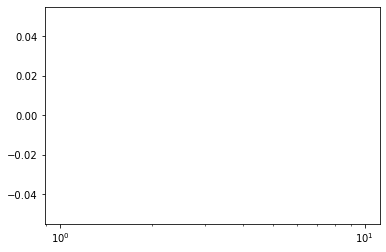

In [72]:
plt.plot(expon_lr_cnn_sgd.rates, expon_lr_cnn_sgd.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr_cnn_sgd.losses), min(expon_lr_cnn_sgd.rates), max(expon_lr_cnn_sgd.rates))
plt.axis([min(expon_lr_cnn_sgd.rates), max(expon_lr_cnn_sgd.rates), 0, expon_lr_cnn_sgd.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show

In [ ]:
min(expon_lr_cnn_sgd.losses)

In [ ]:
expon_lr_cnn_sgd.rates[np.argmin(expon_lr_cnn_sgd.losses)]

In [3]:
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('model_cnn.h5')

In [4]:
# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 16)                9

In [5]:
loss, acc = new_model.evaluate(X_test, yds_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

NameError: name 'X_test' is not defined